# Multi-modal models

In this exercise we'll be using BERT (a language model) and ResNet (an image classification model) to create a multi-modal model.

# Set up

In [1]:
!pip install transformers torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

First we import our required libraries:


*   torch: the core PyTorch library for deep learning and tensor computations.
*   torch.nn: imports PyTorch's neural network module, which is used to build deep learning models.
*   AutoTokenizer: loads a pre-trained tokenizer.
*   AutoModel: loads a pre-trained transformer model.
*   torchvision/models: contains pre-trained deep learning models
*   torchvision/transforms: provides image preprocessing functions (resizing, normalizing, converting images to tensors)
*   requests: used to download files (like images) from the internet using HTTP requests.
*   PIL/Image: a Python library for working with images (opening images, resizing and converting formats, displaying images)
*   BytesIO: a built-in Python module for handling in-memory binary data and used when downloading an image via requests.


In [2]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from torchvision import models, transforms
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
import torch.optim as optim

The MultimodalModel class is a PyTorch neural network that processes both text and image inputs to determine if an image is relevant to a given text. It uses BERT (bert-base-uncased) to encode text, extracting the [CLS] token representation and reducing its 768-dimensional output to 256 using a linear layer. For images, it uses ResNet-50, removing its classification head and reducing its 2048-dimensional feature vector to 256. These text and image embeddings are concatenated (512D total) and passed through a fully connected (FC) network, which consists of a hidden layer (128 neurons with ReLU activation) and an output layer (1 neuron) for binary classification. The model is trained to predict whether a given text-image pair is relevant or not.

In [3]:
# Define the Multimodal Model
class MultimodalModel(nn.Module):
    def __init__(self, text_model_name="bert-base-uncased"):
        super(MultimodalModel, self).__init__()

        # Text encoder (BERT)
        self.tokenizer = AutoTokenizer.from_pretrained(text_model_name)
        self.text_model = AutoModel.from_pretrained(text_model_name)
        self.text_fc = nn.Linear(768, 256)  # Reduce BERT output dimension

        # Image encoder (ResNet)
        self.image_model = models.resnet50(pretrained=True)
        self.image_model.fc = nn.Identity()  # Remove the classification head
        self.image_fc = nn.Linear(2048, 256)  # Reduce ResNet output dimension

        # Fusion layer
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, text, image):
        # Text encoding
        text_inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
        text_outputs = self.text_model(**text_inputs)
        text_features = text_outputs.last_hidden_state[:, 0, :]  # Use [CLS] token
        text_features = self.text_fc(text_features)

        # Image encoding
        image_features = self.image_model(image)
        image_features = self.image_fc(image_features)

        # Fusion
        combined_features = torch.cat((text_features, image_features), dim=1)
        output = self.fc(combined_features)
        return output, text_features, image_features

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalModel().to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 223MB/s]


We preprocess the image - resizing images to 224×224 (ResNet’s expected input size), converting images to tensors, and normalizing pixel values using ImageNet statistics.
We also import our two test images from my git repo - images of a beach and a car.

In [4]:
# Define the image preprocessing pipeline
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Function to load images from GitHub
def load_image_from_github(repo, filename):
    url = f"https://raw.githubusercontent.com/{repo}/main/{filename}"  # Adjust branch if needed
    response = requests.get(url)
    if response.status_code == 200:
        return Image.open(BytesIO(response.content)).convert("RGB")
    else:
        raise ValueError(f"Failed to load {filename} from GitHub. Status code: {response.status_code}")

# GitHub repository and image filenames
repo = "harrietf/book"
image_filenames = ["beach.jpeg", "car.jpg"]

# Load images from GitHub
images = [image_transform(load_image_from_github(repo, img)) for img in image_filenames]

# Stack images into a batch
images = torch.stack(images)

We pass the text and images through the model, and convert the logits into probabilities (values between 0 and 1).

In [5]:
# Training loop example:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Example batch (replace with your own batch creation logic)
    text = ["A beautiful beach.", "A black cat."]
    labels = torch.tensor([1, 0], dtype=torch.float32).unsqueeze(1).to(device)

    images = torch.stack([image_transform(load_image_from_github(repo, img)) for img in image_filenames]).to(device)

    outputs, _, _ = model(text, images)
    loss = criterion(outputs, labels)  # <-- use labels and outputs here

    loss.backward()
    optimizer.step()

    if (epoch+1) % 1 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.6864
Epoch [2/10], Loss: 0.6758
Epoch [3/10], Loss: 0.6300
Epoch [4/10], Loss: 0.5986
Epoch [5/10], Loss: 0.5476
Epoch [6/10], Loss: 0.5724
Epoch [7/10], Loss: 0.5191
Epoch [8/10], Loss: 0.4370
Epoch [9/10], Loss: 0.4485
Epoch [10/10], Loss: 0.4447


In [6]:
# Forward pass through the model
output, text_features, image_features = model(text, images)

# Apply sigmoid to convert logits to probabilities
probabilities = torch.sigmoid(output)

We now visualize both our images, and the probability the model predicts as to their relevance.

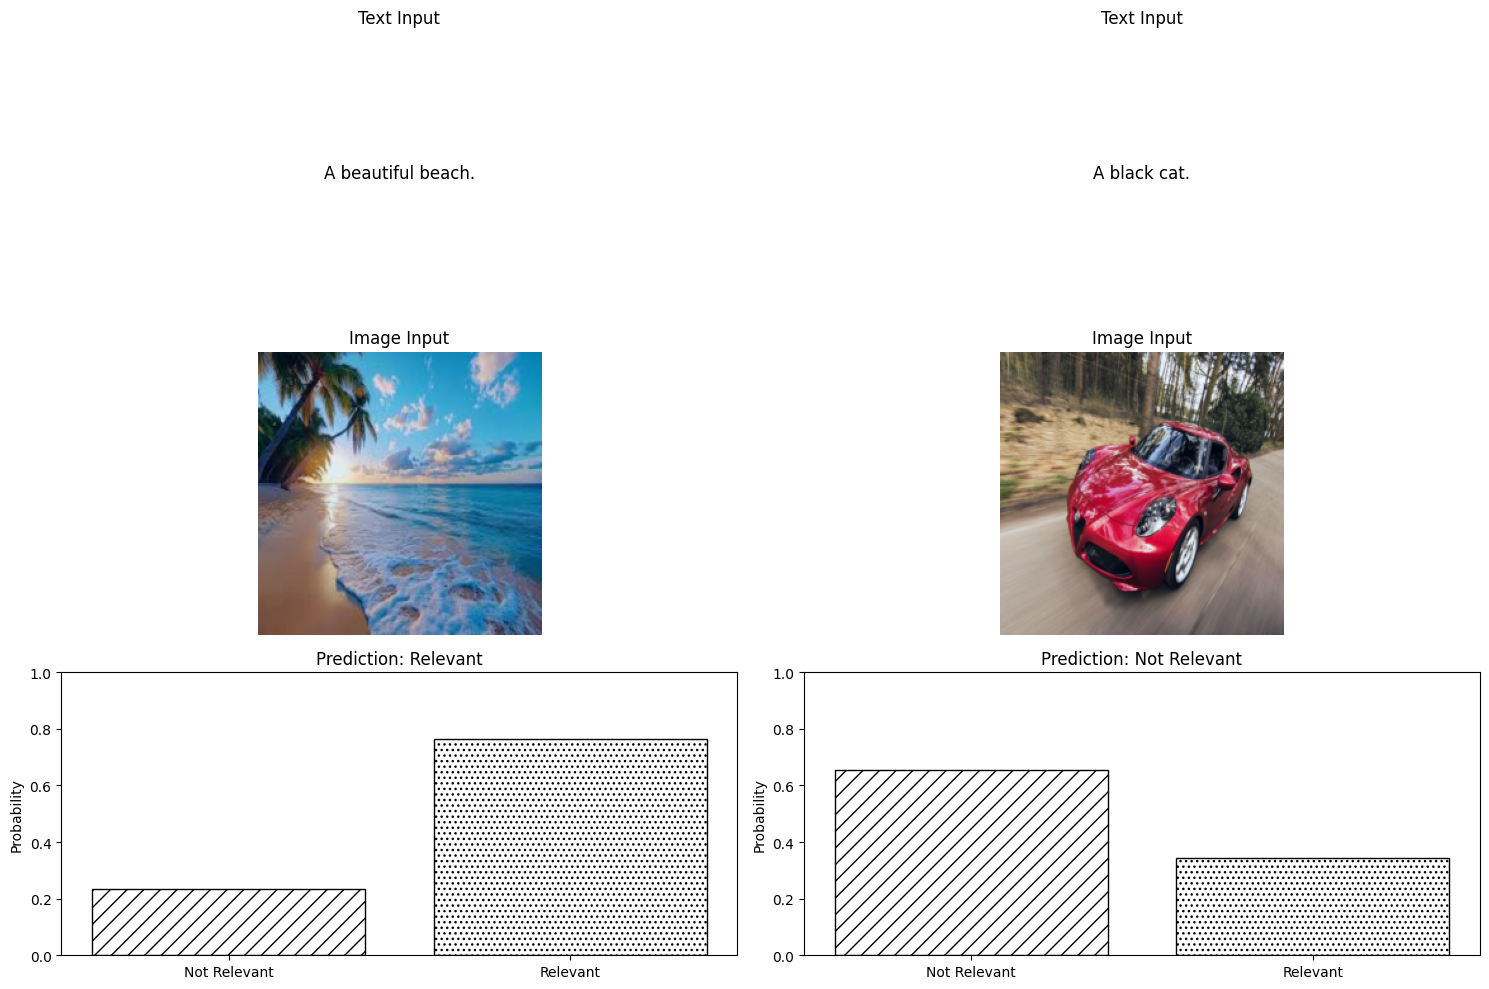

In [7]:
import matplotlib.pyplot as plt

# Visualize the predictions alongside the input
def visualize_predictions(text, images, probabilities):
    fig, axs = plt.subplots(3, len(text), figsize=(15, 10))

    # Text Inputs
    for i, sentence in enumerate(text):
        axs[0, i].text(0.5, 0.5, sentence, fontsize=12, wrap=True, ha='center', va='center')
        axs[0, i].set_title("Text Input")
        axs[0, i].axis("off")

    # Image Inputs
    for i, img_tensor in enumerate(images):
        # Convert tensor to an image
        img_array = img_tensor.permute(1, 2, 0).numpy()
        img_array = (img_array - img_array.min()) / (img_array.max() - img_array.min())  # Normalize to 0-1
        axs[1, i].imshow(img_array, cmap='gray')  # Ensure grayscale
        axs[1, i].set_title("Image Input")
        axs[1, i].axis("off")

    # Predictions
    for i, prob in enumerate(probabilities):
        relevance = "Relevant" if prob.item() >= 0.5 else "Not Relevant"
        axs[2, i].bar(
            ["Not Relevant", "Relevant"],
            [1 - prob.item(), prob.item()],
            color='white',
            edgecolor='black',
            hatch=['//', '...']  # Use different hatch styles for clarity
        )
        axs[2, i].set_title(f"Prediction: {relevance}")
        axs[2, i].set_ylim(0, 1)
        axs[2, i].set_ylabel("Probability")

    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_predictions(
    text=text,
    images=images,
    probabilities=probabilities.squeeze()
)


In [8]:
probabilities

tensor([[0.7657],
        [0.3442]], grad_fn=<SigmoidBackward0>)